## Import dependencies

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import pathlib
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
#print('Keras version:', tf.keras.__version__)

Python version: 3.11.9
Tensorflow version: 2.15.1


In [4]:
import tensorflow as tf
import os
import nvidia.cudnn

CUDNN_PATH = os.path.dirname(nvidia.cudnn.__file__)
print(CUDNN_PATH)

os.environ['LD_LIBRARY_PATH'] = f"{os.getenv('CONDA_PREFIX')}/lib/:{CUDNN_PATH}/lib"
print(os.environ['LD_LIBRARY_PATH'])

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

/home/tao/anaconda3/envs/tfgpu5/lib/python3.11/site-packages/nvidia/cudnn
/home/tao/anaconda3/envs/tfgpu5/lib/:/home/tao/anaconda3/envs/tfgpu5/lib/python3.11/site-packages/nvidia/cudnn/lib
2.15.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-23 17:01:39.849130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:01:39.872441: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:01:39.872553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
cache_dir = '/home/tao/computer-vision/dataset';

## Load dataset

In [9]:
DATASET_NAME = 'quickdraw_bitmap'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir=cache_dir,
    with_info=True,
    split=tfds.Split.TRAIN,
)

2024-05-23 17:01:50.848017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:01:50.848141: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:01:50.848209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Explore dataset

In [11]:
image_shape = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples

print('num_examples: ', num_examples)
print('image_shape: ', image_shape)
print('num_classes: ', num_classes)

num_examples:  50426266
image_shape:  (28, 28, 1)
num_classes:  345


In [12]:
label_index_to_string = dataset_info.features['label'].int2str

classes = []

for class_index in range(num_classes):
    classes.append(label_index_to_string(class_index))

print('classes num:', len(classes))
print('classes:\n\n', classes)

classes num: 345
classes:

 ['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'divin

In [13]:
print(dataset)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [15]:
def dataset_preview(dataset, image_shape, preview_images_num=100):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(17, 17))
    image_size = image_shape[0]

    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example['image']
        label = example['label']

        class_index = label.numpy()
        class_name = classes[class_index]

        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [16]:
def dataset_normalized_preview(dataset, image_shape, preview_images_num=100):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(17, 17))
    image_size = image_shape[0]

    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example[0]
        label = tf.math.argmax(example[1])

        class_index = label.numpy()
        class_name = label_index_to_string(class_index)

        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [17]:
def dataset_head(ds):
    for example in ds.take(1):
        image = example['image']
        label = example['label']

        class_index = label.numpy()
        class_name = label_index_to_string(class_index)

        print('{} ({})'.format(class_name, class_index), '\n')
        print('Image shape: ', image.shape, '\n')
        print(np.reshape(image.numpy(), (28, 28)), '\n')

In [18]:
dataset_head(dataset)

backpack (12) 

Image shape:  (28, 28, 1) 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   3  31  63  95 115
   86  50   2   0   0   0   0   0   0   0]
 [  0   0   0   0   0  75 183 176 152  10  54 182 222 250 255 255 255 255
  255 255 231 151  61   0   0   0   0   0]
 [  0   0   0   0 129 255 216 202 255  98 220 222 157 125  93  60  28   8
   38  82 162 239 254 108   0   0   0   0]
 [  0   0   0  33 250 158   4   0 204 209 255 236 105   0   0   0   0   0
    0   0   0   6 164 254  88   0   0   0]
 [  0   0   0 158 243  30 155 235 211 255 254 185 255  97   0   0   0   0
    0   0   0   0   3 193 229  10   0   0]
 [  0   0  38 251 134 153 251 162 252 245 225   1 180 241   6   0   0   0
    0   0   0   0   0  69 255  62   0   0]
 [  0   0 150 240  26 245 145   0 116 255 149   0  75 255  58   0   0   0
    0   0   0   0   0  29 255  94   0   0]
 [  0   0 209 173  7

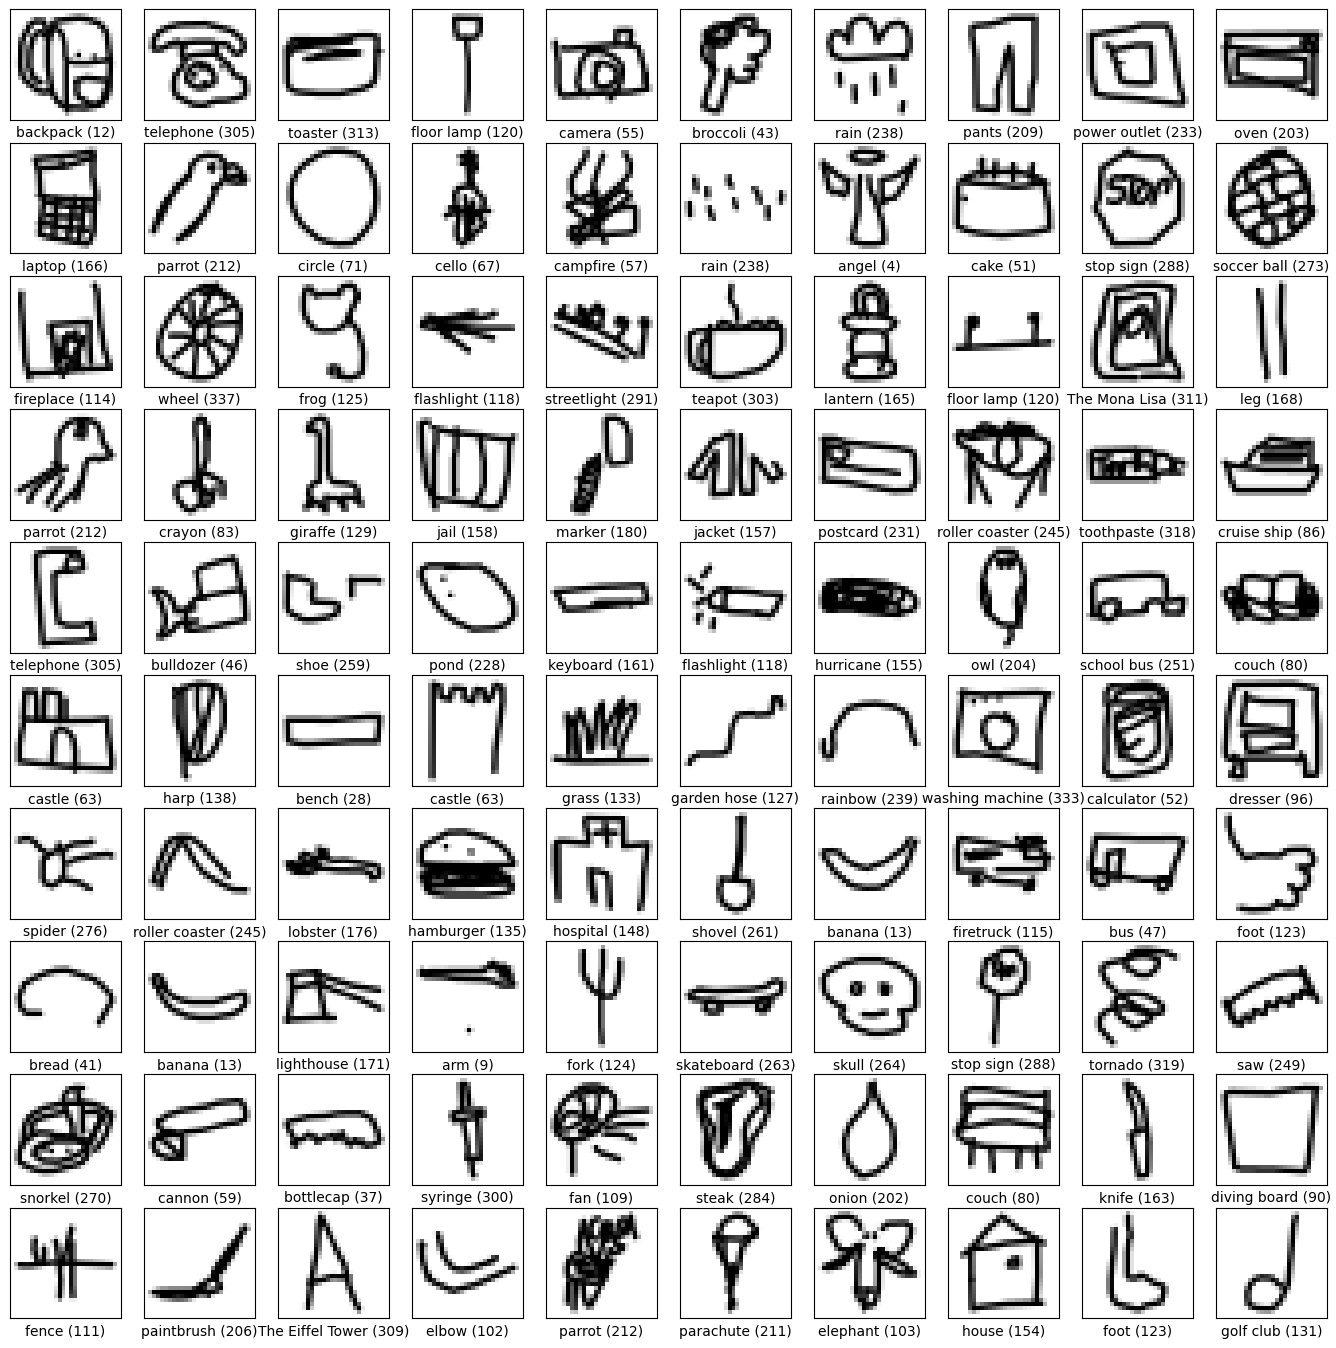

In [19]:
dataset_preview(dataset, image_shape)

## Normalize dataset

In [20]:
def normalize_example(example):
    image = example['image']
    label = example['label']
    label = tf.one_hot(label, len(classes))

    image = tf.math.divide(image, 255)

    return (image, label)

In [21]:
def augment_example(image, label):
    image = tf.image.random_flip_left_right(image)
    return (image, label)

In [22]:
dataset_normalized = dataset.map(normalize_example).map(augment_example)

In [23]:
for (image, label) in dataset_normalized.take(1):
    class_index = tf.math.argmax(label).numpy()
    class_name = label_index_to_string(class_index)

    print('{} ({})'.format(class_name, class_index), '\n')
    print('Image shape: ', image.shape, '\n')
    print(np.reshape(image.numpy(), (28, 28)), '\n')

backpack (12) 

Image shape:  (28, 28, 1) 

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.01176471 0.12156863 0.24705882 0.37254903 0.4509804
  0.3372549  0.19607843 0.00784314 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.29411766
  0.7176471  0.6901961  0.59607846 0.03921569 0.21176471 0.7137255
  0.87058824 0.98039216 1.         1.         1.         1.
  1.         1.         0.90588236 0.5921569  0.23921569 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5058824  1.
  0.84705883 

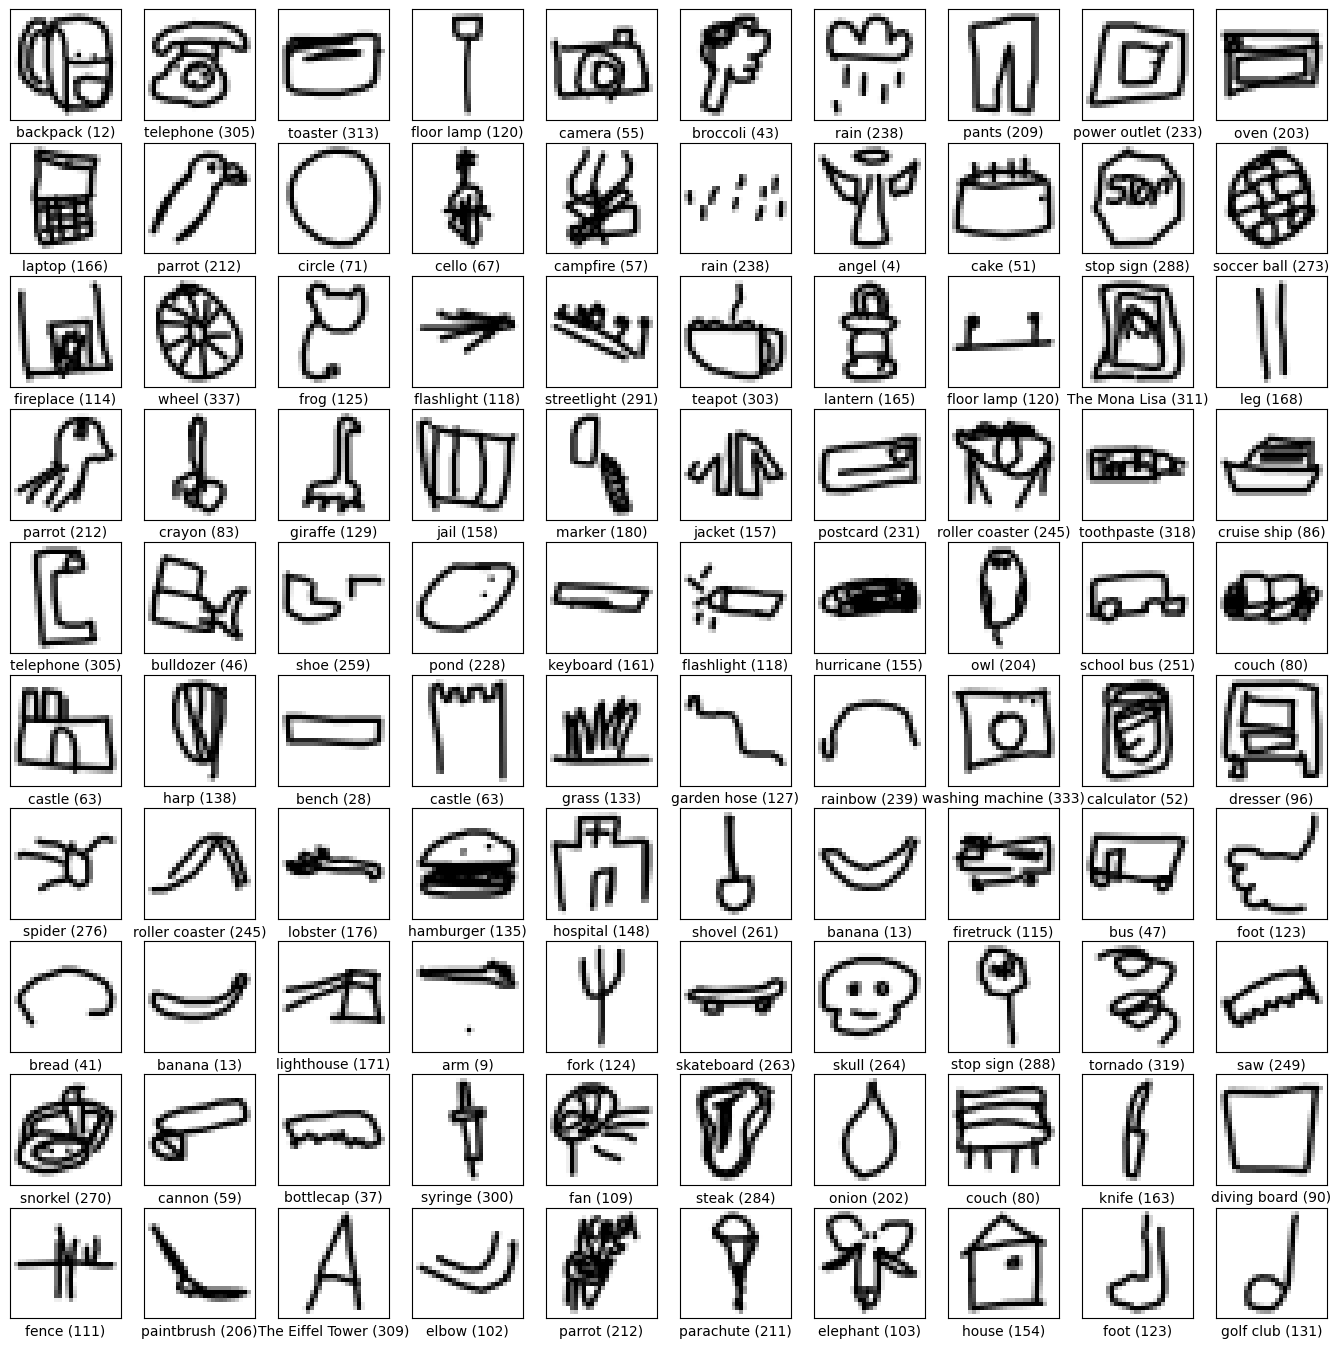

In [24]:
dataset_normalized_preview(dataset_normalized, image_shape)

## Prepare Train/Validation/Test dataset splits

In [25]:
# A quick example of how we're going to split the dataset for train/test/validation subsets.
tmp_ds = tf.data.Dataset.range(10)
print('tmp_ds:', list(tmp_ds.as_numpy_iterator()))

tmp_ds_test = tmp_ds.take(2)
print('tmp_ds_test:', list(tmp_ds_test.as_numpy_iterator()))

tmp_ds_val = tmp_ds.skip(2).take(3)
print('tmp_ds_val:', list(tmp_ds_val.as_numpy_iterator()))

tmp_ds_train = tmp_ds.skip(2 + 3)
print('tmp_ds_train:', list(tmp_ds_train.as_numpy_iterator()))

tmp_ds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp_ds_test: [0, 1]
tmp_ds_val: [2, 3, 4]
tmp_ds_train: [5, 6, 7, 8, 9]


In [26]:
# Dataset split
test_dataset_batches = 1
val_dataset_batches = 1

# Dataset batching
batch_size = 512
prefetch_buffer_batches = 10
epochs = 200

# Training
steps_per_epoch = 500

In [27]:
dataset_batched = dataset_normalized.batch(batch_size=batch_size)

In [28]:
# TEST dataset.
dataset_test = dataset_batched \
    .take(test_dataset_batches)

# VALIDATION dataset.
dataset_val = dataset_batched \
    .skip(test_dataset_batches) \
    .take(val_dataset_batches)

# TRAIN dataset.
dataset_train = dataset_batched \
    .skip(test_dataset_batches + val_dataset_batches) \
    .prefetch(buffer_size=prefetch_buffer_batches) \
    .repeat()

In [29]:
for (image_test, label_test) in dataset_test.take(1):
    print('label_test.shape: ', label_test.shape)
    print('image_test.shape: ', image_test.shape)

print()

for (image_val, label_val) in dataset_val.take(1):
    print('label_val.shape: ', label_val.shape)
    print('image_val.shape: ', image_val.shape)

print()

for (image_train, label_train) in dataset_train.take(1):
    print('label_train.shape: ', label_train.shape)
    print('image_train.shape: ', image_train.shape)

label_test.shape:  (512, 345)
image_test.shape:  (512, 28, 28, 1)

label_val.shape:  (512, 345)
image_val.shape:  (512, 28, 28, 1)

label_train.shape:  (512, 345)
image_train.shape:  (512, 28, 28, 1)


In [30]:
# Calculate how many times the network will "see" each class during one epoch of training
# given specific dataset (batches) and number of steps per epoch.
def get_dataset_classes_hist(dataset, classes, batches_num):
    mentions = {class_name: 0 for class_name in classes}
    for examples, labels in dataset.take(batches_num):
        for label in labels:
            class_name = classes[tf.math.argmax(label).numpy()]
            mentions[class_name] += 1
    return mentions;

## Create model

In [31]:
def resnet_block(input_tensor, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """A residual block for ResNet"""
    if conv_shortcut:
        shortcut = Conv2D(filters, 1, strides=stride)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = ReLU()(x)
    return x

def ResNet18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 3, strides=1, padding='same')(inputs)  # Adjusted to fit 28x28 input
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Stacks
    for filters in [64, 128, 256, 512]:
        for i in range(2):
            if i == 0 and filters != 64:
                x = resnet_block(x, filters, stride=2)
            else:
                x = resnet_block(x, filters, conv_shortcut=False)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Dataset parameters
input_shape = (28, 28, 1)
num_classes = 345  # Adjusted to 345 categories

# Create and compile the ResNet-18 model
model = ResNet18(input_shape=input_shape, num_classes=num_classes)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 28, 28, 64)           0         ['batch_normalization[0][0

In [33]:
#tf.keras.utils.plot_model(
#    model,
#    show_shapes=True,
#    show_layer_names=True,
#)

In [34]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
rms_prop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

## Train model

In [35]:
import tensorflow as tf
tf.keras.backend.clear_session()


In [36]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True,
    verbose=1
)

In [37]:
training_history = model.fit(
    x=dataset_train,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    callbacks=[
        early_stopping_callback
    ]
)

Epoch 1/200


2024-05-23 17:01:58.099054: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-23 17:01:59.530437: I external/local_xla/xla/service/service.cc:168] XLA service 0x5a36cea0abc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 17:01:59.530453: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-23 17:01:59.534052: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716501719.596969 3171494 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


500/500 [==============================] - 57s 90ms/step - loss: 2.7831 - accuracy: 0.3781 - val_loss: 2.4648 - val_accuracy: 0.4258
Epoch 2/200
500/500 [==============================] - 43s 86ms/step - loss: 1.7558 - accuracy: 0.5739 - val_loss: 1.8696 - val_accuracy: 0.5469
Epoch 3/200
500/500 [==============================] - 43s 86ms/step - loss: 1.5315 - accuracy: 0.6234 - val_loss: 1.5255 - val_accuracy: 0.6270
Epoch 4/200
500/500 [==============================] - 43s 87ms/step - loss: 1.4279 - accuracy: 0.6467 - val_loss: 1.4985 - val_accuracy: 0.6504
Epoch 5/200
500/500 [==============================] - 43s 86ms/step - loss: 1.3494 - accuracy: 0.6639 - val_loss: 1.4383 - val_accuracy: 0.6426
Epoch 6/200
500/500 [==============================] - 43s 86ms/step - loss: 1.3016 - accuracy: 0.6752 - val_loss: 1.3151 - val_accuracy: 0.6641
Epoch 7/200
500/500 [==============================] - 43s 87ms/step - loss: 1.2608 - accuracy: 0.6848 - val_loss: 1.2910 - val_accuracy: 0.68

In [38]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

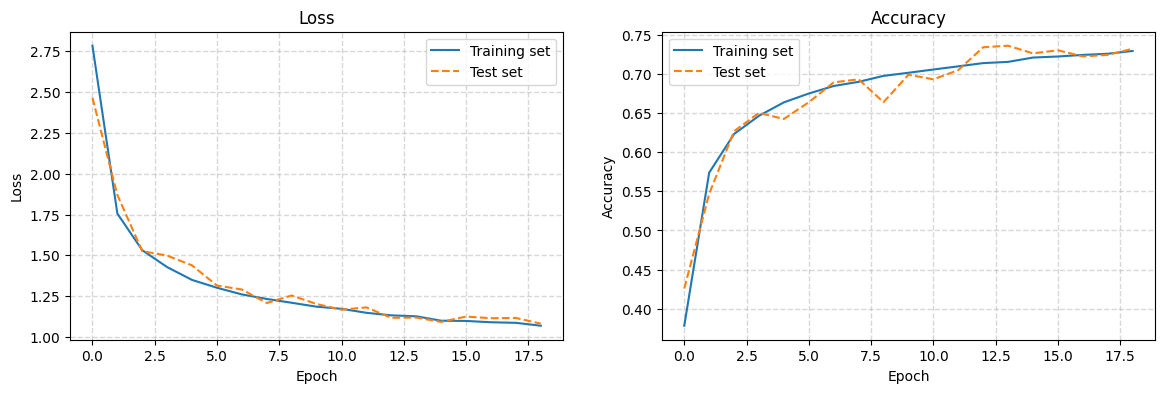

In [39]:
render_training_history(training_history)

## Evaluate model accuracy

### Training set accuracy

In [40]:
%%capture
train_loss, train_accuracy = model.evaluate(dataset_train.take(1))

In [41]:
print('Train loss: ', '{:.2f}'.format(train_loss))
print('Train accuracy: ', '{:.2f}'.format(train_accuracy))

Train loss:  1.18
Train accuracy:  0.70


### Validation set accuracy

In [42]:
%%capture
val_loss, val_accuracy = model.evaluate(dataset_val)

In [43]:
print('Validation loss: ', '{:.2f}'.format(val_loss))
print('Validation accuracy: ', '{:.2f}'.format(val_accuracy))

Validation loss:  1.12
Validation accuracy:  0.73


### Test set accuracy

In [44]:
%%capture
test_loss, test_accuracy = model.evaluate(dataset_test)

In [45]:
print('Test loss: ', '{:.2f}'.format(test_loss))
print('Test accuracy: ', '{:.2f}'.format(test_accuracy))

Test loss:  1.15
Test accuracy:  0.72


### Visualizing Predictions

In [46]:
def visualize_predictions(model, dataset):
    numbers_to_display = 64
    num_cells = math.ceil(math.sqrt(numbers_to_display))
    plt.figure(figsize=(15, 15))

    batch = dataset.take(1)
    predictions = tf.math.argmax(model.predict(batch), axis=1).numpy()

    for x, y in batch:
        for image_index in range(numbers_to_display):
            pixels = np.reshape(x[image_index].numpy(), (28, 28))
            y_correct = tf.math.argmax(y[image_index]).numpy()
            y_predicted = predictions[image_index]
            correct_label = classes[y_correct]
            predicted_label = classes[y_predicted]

            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            color_map = 'Greens' if y_correct == y_predicted else 'Reds'
            plt.subplot(num_cells, num_cells, image_index + 1)
            plt.imshow(pixels, cmap=color_map)
            plt.xlabel(correct_label + ' --> ' + predicted_label)

    plt.subplots_adjust(hspace=1, wspace=0.5)
    plt.show()

1/1 [==============================] - 0s 381ms/step


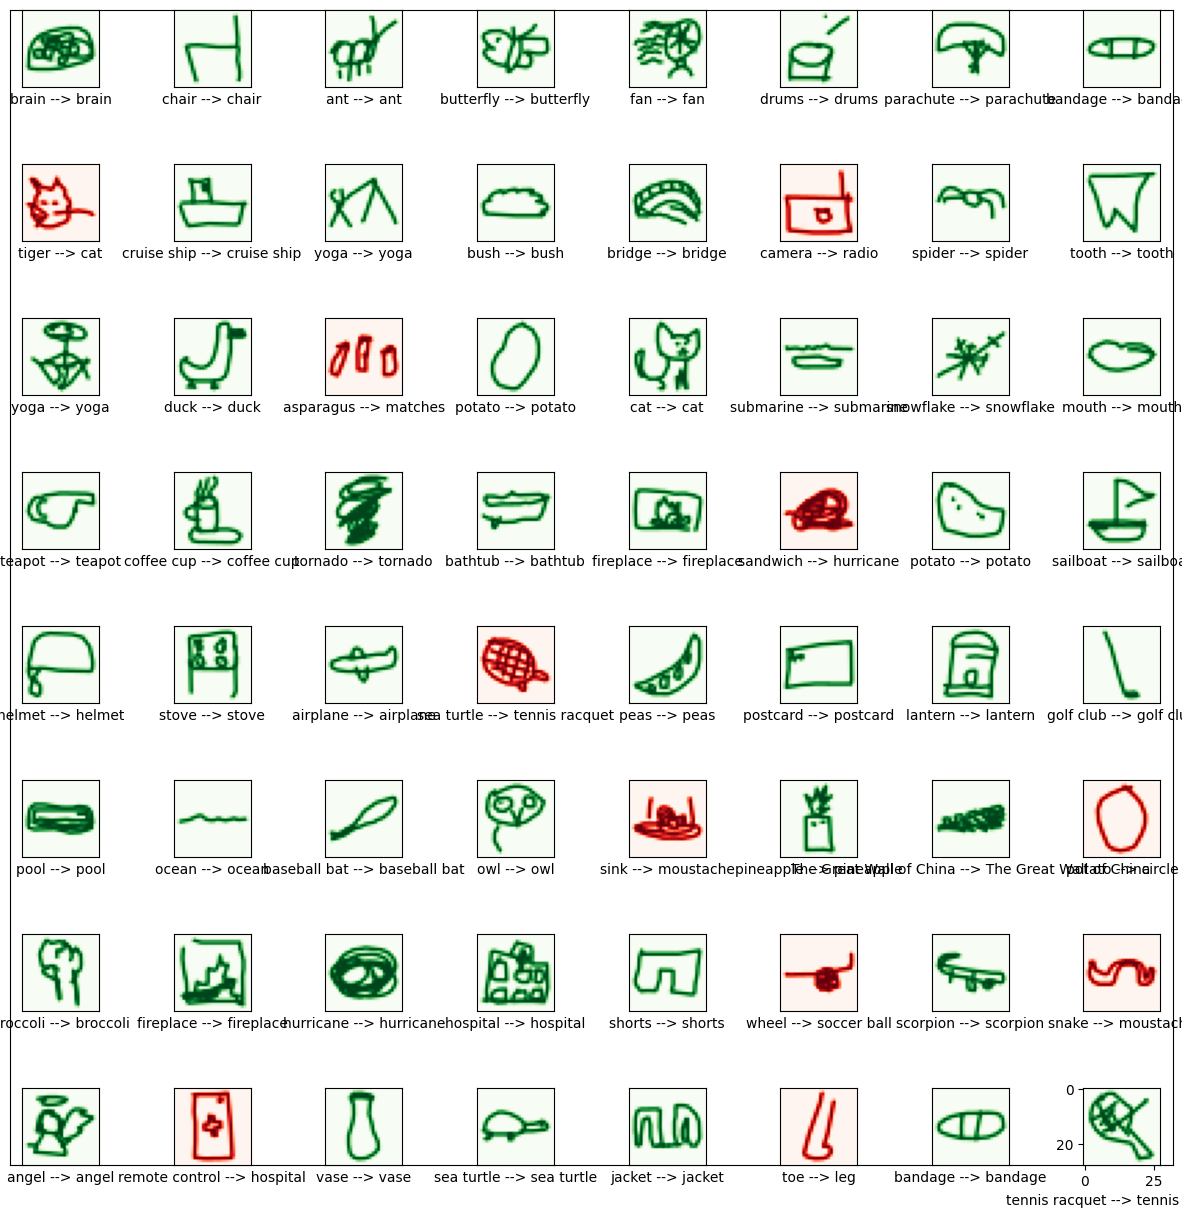

In [47]:
visualize_predictions(model, dataset_train)

1/1 [==============================] - 0s 113ms/step


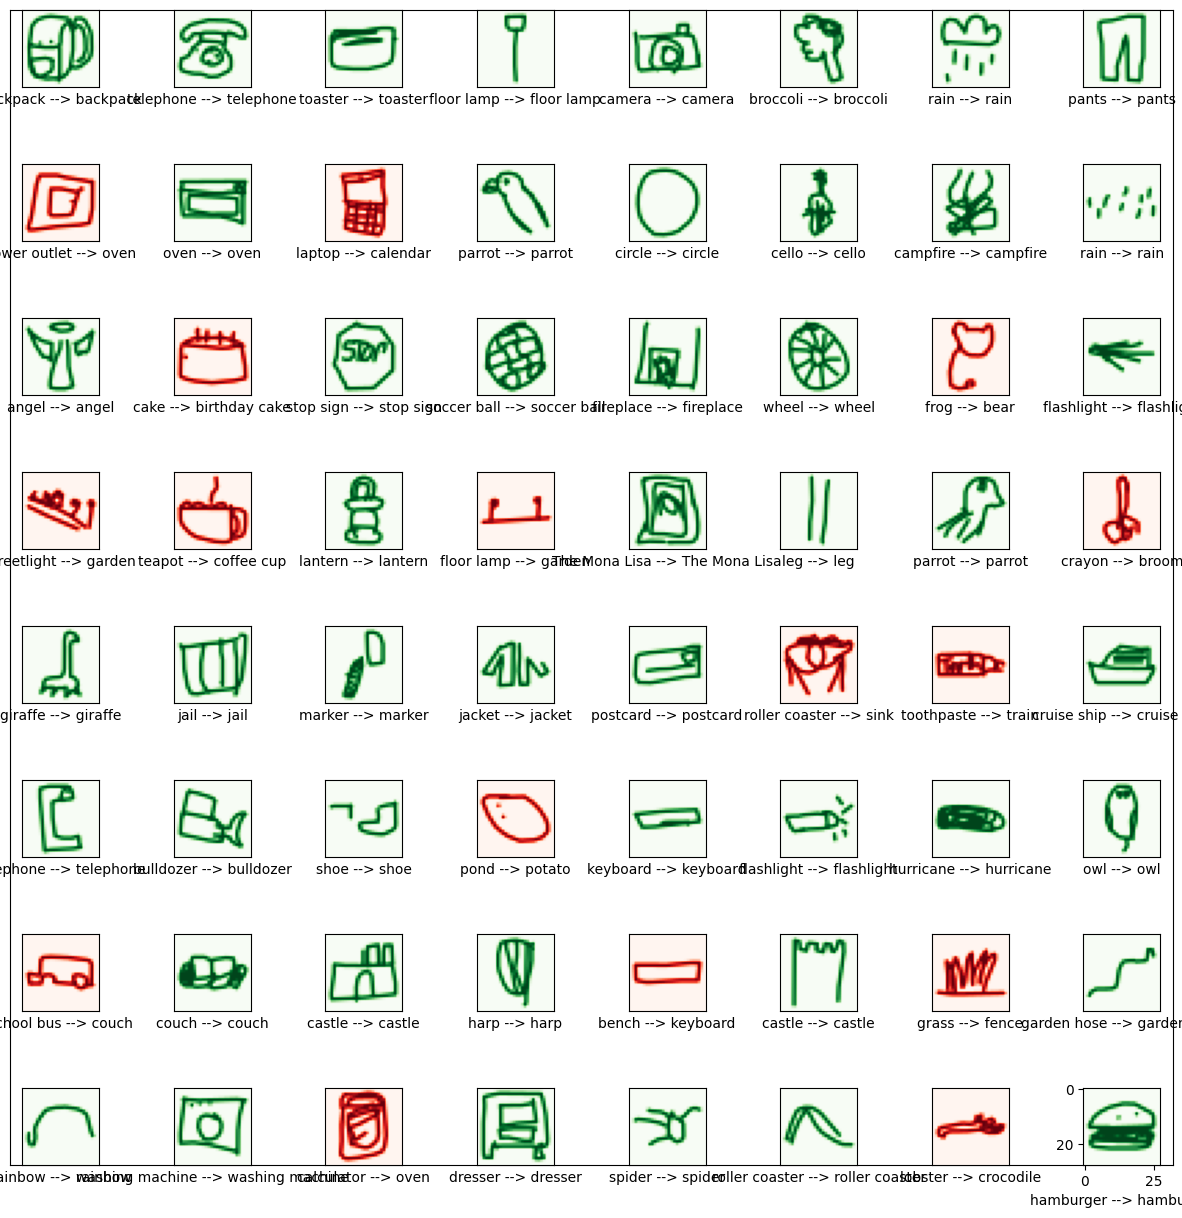

In [48]:
visualize_predictions(model, dataset_test)

## Save the model

In [50]:
model.save('resnet_my_model.keras')